<a href="https://colab.research.google.com/github/ZZongSeung/ALEXNET-algorithm/blob/main/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, dataset
from torch.optim import Adam
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

## 문제 정의
----
- AlexNet
    - AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up.


![AlexNet](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/720px-Comparison_image_neural_networks.svg.png)

In [2]:
# CIFAR 데이터 불러오기
train_img = datasets.CIFAR10(
    root = '/content',
    train = True,
    download = True,
    transform = transforms.ToTensor(),
)

test_img = datasets.CIFAR10(
    root = '/content',
    train = False,
    download = True,
    transform = transforms.ToTensor(),
)

100%|██████████| 170498071/170498071 [00:20<00:00, 8382503.55it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content
    Split: Train
    StandardTransform
Transform: ToTensor()

In [80]:
# 데이터 증강 표현
mean = train_img.data.mean(axis=(0,1,2)) / 255
std = train_img.data.std(axis=(0,1,2)) / 255

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std), # 3차원 RGB로 구성되어 있는 값
    transforms.RandomCrop(size=train_img.data.shape[1], padding=4), # 32*32image 크기와 padding= 4 를 적용해서 이미지를 slicing 해보자
    transforms.RandomHorizontalFlip(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)]) # 여기서 증강은 안시킨다 -> 검증용 데이터이기 땨문에

In [81]:
# 위의 값들을 적용해서 다시 데이터를 불러온다 - 증강
train_img2 = datasets.CIFAR10(
    root = '/content',
    train = True,
    download = True,
    transform = transform_train
)

test_img2 = datasets.CIFAR10(
    root = '/content',
    train = False,
    download = True,
    transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [82]:
# 이미지 생성위한 datasets / dataloader
# 여기서도 정제됐기 때문에 dataloader로만 생성

train_loader = DataLoader(train_img2, batch_size = 128, shuffle=True)
test_loader = DataLoader(test_img2, batch_size = 128, shuffle=True)

# dataloader 상태에서 데이터를 보고 싶은 경우
data, target = next(iter(train_loader))

In [83]:
print(data.shape) # input - torch.Size([1, 3, 32, 32])
print(target.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


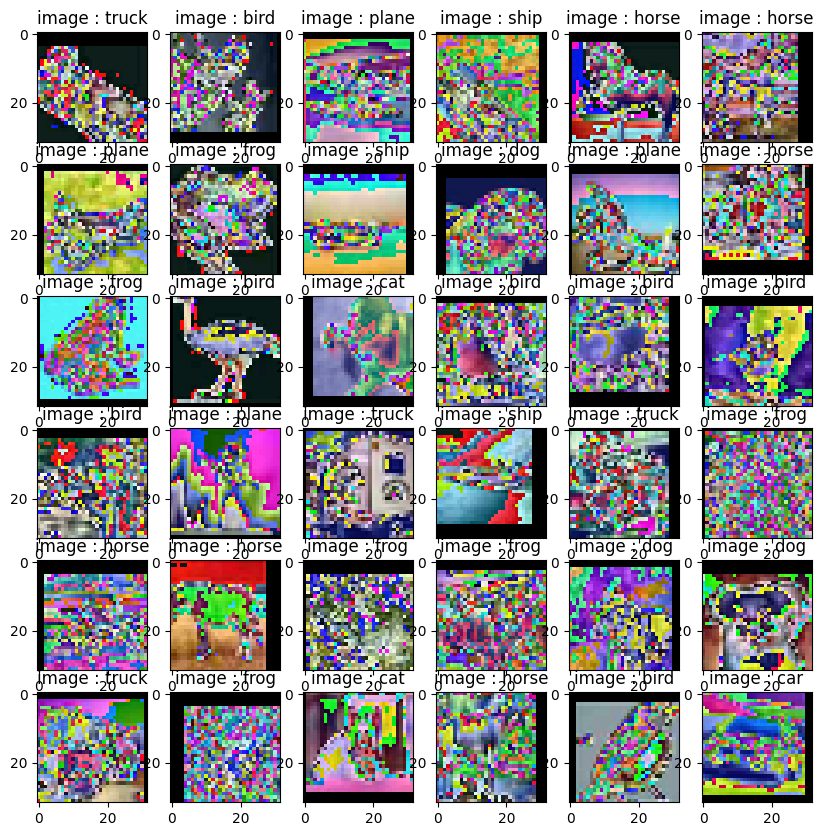

In [85]:
# 이미지 그래프
# target
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
np.random.seed(1234)

from torchvision.transforms.functional import to_pil_image
# image plot
row = 6; col = 6
fig, axs = plt.subplots(row, col, figsize = (10,10))


for i in range(row):
  for j in range(col):
    index = i*col+j
    if index < row*col:
      indice = np.random.randint(len(train_img2))
      img, target = train_img2[indice] # 3차원의 RGB을 해결하려면 PIL_to_image를 생성해서 접근해야 함.
      axs[i,j].imshow(to_pil_image(img))
      axs[i,j].set_title(f"image : {labels_map[target]}")
    else:
      fig.delaxes(axs[i,j])

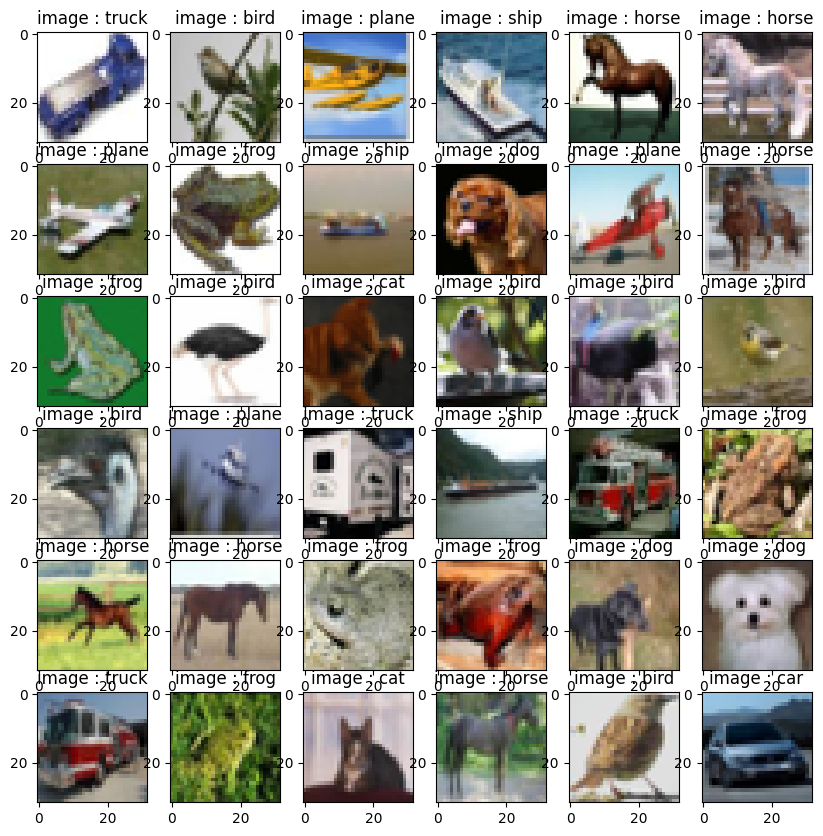

In [86]:
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
np.random.seed(1234)
from torchvision.transforms.functional import to_pil_image
# image plot
row = 6; col = 6
fig, axs = plt.subplots(row, col, figsize = (10,10))

for i in range(row):
  for j in range(col):
    index = i*col+j
    if index < row*col:
      indice = np.random.randint(len(train_img))
      img, target = train_img[indice]
      axs[i,j].imshow(to_pil_image(img)) # 3차원의 RGB 그림 해결
      axs[i,j].set_title(f"image : {labels_map[target]}")
    else:
      fig.delaxes(axs[i,j])

# hyper parameter

In [66]:
lr = 1e-4
epochs = 20
batch_size = 128

# cpu할당량 초과로 실행안됨.
if torch.cuda.is_available()==True:
  device = torch.device("cuda")
  print(device)
else:
  device = torch.device("cpu")
  print(device)


cuda


## 문제 정의
----
- AlexNet
    - AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up.


![AlexNet](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/720px-Comparison_image_neural_networks.svg.png)

In [87]:
# 본격 모델 생성

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 4096),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [88]:
# opimizer
model = AlexNet().to(device)
from torch.optim import Adam
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
loss = nn.CrossEntropyLoss()

In [89]:
# train_loop
def train_loop(train_loader, model, loss_fn, optimizer):
  model.train()
  size = len(train_loader.dataset)

  for batch, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    # 모델에 넣은 예측값 생성
    pred = model(data)

    # 손실 정의
    loss = loss_fn(pred, target)

    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(data)
      print(f'loss: {loss:>7f}  [{current:>5d}]/{size:5d}')

In [58]:
for i in range(2):
  train_loop(train_loader, model, loss, optimizer)

loss : 2.3035202026367188 / [0  / 50000]
loss : 2.300798177719116 / [12800  / 50000]
loss : 2.3022375106811523 / [25600  / 50000]
loss : 2.3032169342041016 / [38400  / 50000]
loss : 2.3075919151306152 / [0  / 50000]
loss : 2.3029091358184814 / [12800  / 50000]
loss : 2.3048927783966064 / [25600  / 50000]
loss : 2.301332473754883 / [38400  / 50000]


In [92]:
epochs = 20
best_correct = 0.0  # 가장 높은 정확도를 저장할 변수
best_epoch = 0      # 가장 높은 정확도를 가진 에포크 번호를 저장할 변수

# 최적 epochs일 때 예측값을 넣기
best_real = []
best_predict = []
error = {}

for i in range(30):  # 에포크 횟수
    print(f"Epoch {i+1} \n------------------------")
    train_loop(train_loader, model, loss, optimizer)

    # test_loop 임--------------------------------------------.
    set_size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss = 0
    correct = 0

    current_real = []
    current_predict = []

    with torch.no_grad():
        for batch, (input, target) in enumerate(test_loader):
            input, target = input.to(device), target.to(device)
            pred = model(input)

            test_loss += loss(pred, target).item()  # 각 배치 손실 더하기
            correct += (pred.argmax(1) == target).type(torch.float).sum().item()  # 정확한 예측 수 더하기

            # 현재 배치의 예측 값과 실제 값을 저장
            current_predict.extend(pred.argmax(1).cpu().numpy())
            current_real.extend(target.cpu().numpy())

    test_loss /= num_batches  # 에포크 전체에 대한 평균 손실
    correct /= set_size       # 에포크 전체에 대한 정확도
    error[i]=test_loss   # 에포크 별 에러 저장
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:8f}\n")

    # 정확도에 따른 best epoch 업데이트
    if correct > best_correct:
        best_correct = correct
        best_epoch = i + 1
        best_predict = current_predict  # 최적 에포크의 예측 값 저장
        best_real = current_real        # 최적 에포크의 실제 값 저장

print(f"Best epoch is {best_epoch} with an accuracy of {best_correct*100:.1f}%")

Epoch 1 
------------------------
loss: 0.912442  [    0]/50000
loss: 0.800303  [12800]/50000
loss: 1.075100  [25600]/50000
loss: 0.873990  [38400]/50000
Test Error: 
 Accuracy: 69.1%, Avg loss: 0.883300

Epoch 2 
------------------------
loss: 1.031140  [    0]/50000
loss: 0.720932  [12800]/50000
loss: 0.751314  [25600]/50000
loss: 1.038567  [38400]/50000
Test Error: 
 Accuracy: 68.6%, Avg loss: 0.885966

Epoch 3 
------------------------
loss: 0.870651  [    0]/50000
loss: 1.127824  [12800]/50000
loss: 0.999651  [25600]/50000
loss: 0.683755  [38400]/50000
Test Error: 
 Accuracy: 70.4%, Avg loss: 0.836327

Epoch 4 
------------------------
loss: 0.840431  [    0]/50000
loss: 0.942359  [12800]/50000
loss: 0.698587  [25600]/50000
loss: 0.842183  [38400]/50000
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.845487

Epoch 5 
------------------------
loss: 0.811314  [    0]/50000
loss: 0.784892  [12800]/50000
loss: 0.833225  [25600]/50000
loss: 0.742116  [38400]/50000
Test Error: 
 Accuracy: 69

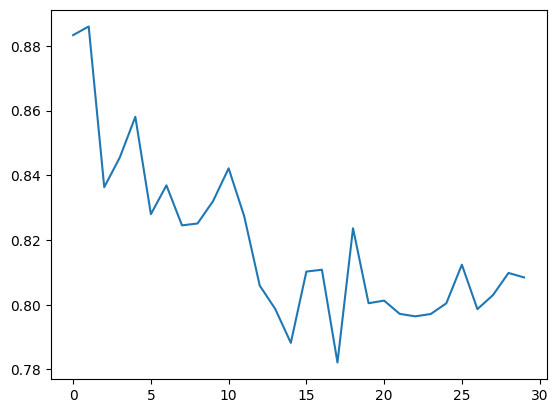

In [101]:
plt.plot(error.values()) # test_value의 error 생성